<a href="https://colab.research.google.com/github/rpdieego/IBMWatson_RecommendationEngine/blob/master/Recommendations_with_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [0]:
# Code to read files from Google Drive into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Import from Google Drive

link = 'https://drive.google.com/open?id=12JLzic4hraiGpvqlW_JFkS-SXFs-ErCI'

fluff, id = link.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('project_tests.py')
import project_tests as t

12JLzic4hraiGpvqlW_JFkS-SXFs-ErCI


In [3]:
# Import from Google Drive

link_top5 = 'https://drive.google.com/open?id=1bpyTMMnAYbVbI9LH0DOEWIVdU_pgQImW'

fluff, id = link_top5.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('top_5.p')

1bpyTMMnAYbVbI9LH0DOEWIVdU_pgQImW


In [4]:
# Import from Google Drive

link_top10 = 'https://drive.google.com/open?id=1pxWNjM6SBqMRLFdv0MGo9yDKb_fwY2RN'

fluff, id = link_top10.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('top_10.p')

1pxWNjM6SBqMRLFdv0MGo9yDKb_fwY2RN


In [5]:
# Import from Google Drive

link_top20 = 'https://drive.google.com/open?id=10KlI8oufQsjeex1mJH4ryxXOJcm6Hcm0'

fluff, id = link_top20.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('top_20.p')

10KlI8oufQsjeex1mJH4ryxXOJcm6Hcm0


In [6]:
# Import from Google Drive

link_matrix = 'https://drive.google.com/open?id=1ifkWMMbR7NkoXUe6otOlbDn0FvgUwnLF'

fluff, id = link_matrix.split('=')
print (id) # Verify that we have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('user_item_matrix.p')

1ifkWMMbR7NkoXUe6otOlbDn0FvgUwnLF


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score

%matplotlib inline

In [8]:

url = 'https://raw.githubusercontent.com/rpdieego/IBMWatson_RecommendationEngine/master/user-item-interactions.csv'
url_content = 'https://raw.githubusercontent.com/rpdieego/IBMWatson_RecommendationEngine/master/articles_community.csv'

df = pd.read_csv(url)
df_content = pd.read_csv(url_content)
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [0]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [0]:
# Count unique users and interaction frequency

df['user_id'] = df[ df['email'].isnull() == False].groupby('email').ngroup()

unique_user, interaction_freq = np.unique(df['user_id'], return_counts=True)

In [0]:
df = df.drop('user_id', axis=1)

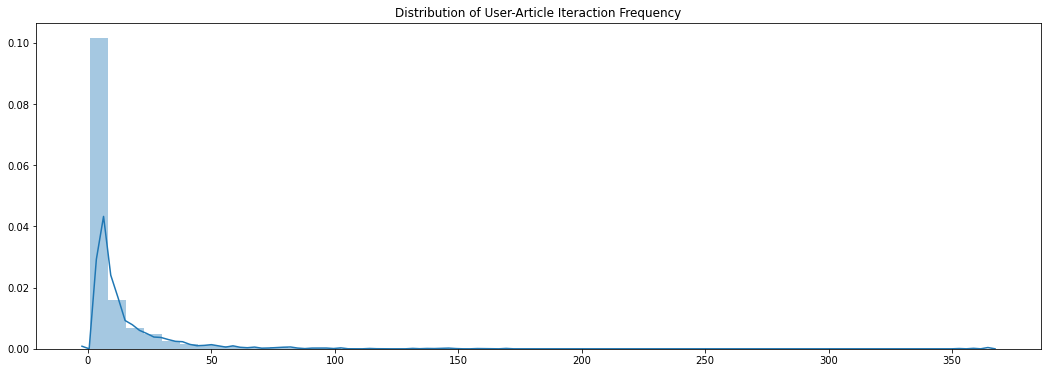

In [0]:
#Distribution Plot of User-Article Iteraction Frequency
plt.figure(figsize = (18,6));
plt.title('Distribution of User-Article Iteraction Frequency')
sns.distplot(interaction_freq);
plt.show()

In [0]:
# Maximum number ob user-article interaction by any 1 user
interaction_freq.max()

364

In [0]:
# Median of user-article interaction
np.median(interaction_freq)

3.0

In [0]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [0]:
# Find and explore duplicate articles
n_duplicates = df_content.shape[0] - df_content['article_id'].nunique()
print('Number of duplicate articles in the dataset: {}'.format(n_duplicates))

Number of duplicate articles in the dataset: 5


In [0]:
# Remove any rows that have the same article_id - only keep the first

In [0]:
# Duplicated article_ids
unique_article, article_freq = np.unique(df_content['article_id'], return_counts=True)
np.where(article_freq == 2)

(array([ 50, 221, 232, 398, 577]),)

In [0]:
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

In [0]:
# Check if all the duplicates where removed
n_duplicates_new = df_content.shape[0] - df_content['article_id'].nunique()
print('Number of duplicate articles in the dataset: {}'.format(n_duplicates_new))

Number of duplicate articles in the dataset: 0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [0]:
# Number of articles with at leats one interaction
df['article_id'].nunique()


714

In [0]:
# Number of unique articles
df_content['article_id'].nunique()

1051

In [0]:
# Number of users with null values
len((df[df['email'].isnull() == True]).index)

17

In [0]:
# Number of unique users
df[df['email'].isnull() == False]['email'].nunique()

5148

In [0]:
# Number of user-article interactions
df.shape[0]

45993

In [0]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [0]:
# How many time the most viewed article has been seen?
unique_viewed_article, article_view_freq = np.unique(df['article_id'], return_counts=True)
article_view_freq.max()

937

In [0]:
unique_viewed_article[np.where(article_view_freq == 937)]

array([1429.])

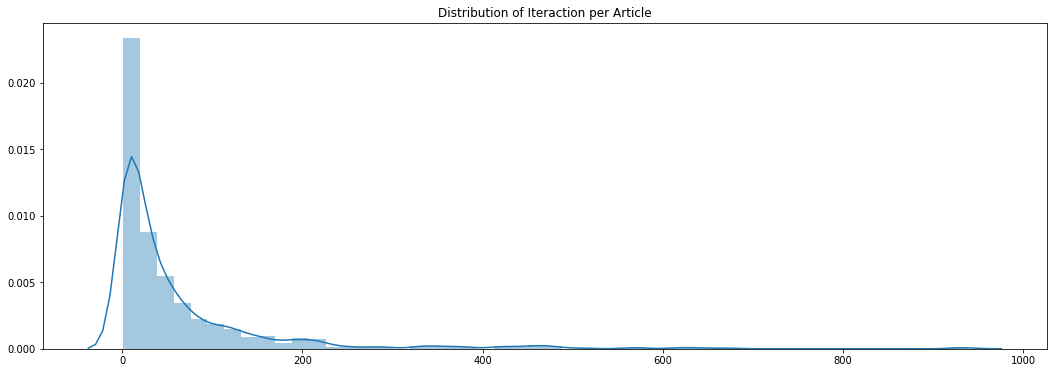

In [0]:
#Distribution Plot of User-Article Iteraction Frequency
plt.figure(figsize = (18,6));
plt.title('Distribution of Iteraction per Article')
sns.distplot(article_view_freq);
plt.show()

In [0]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [9]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [0]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [0]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    # Get unique articles and how many times they were viewed
    unique_viewed_article, article_view_freq = np.unique(df['article_id'], return_counts=True)

    # Create a Dataframe containing |article_id|article_views|
    article_df = pd.DataFrame({'article_id':unique_viewed_article, 'article_views':article_view_freq })
    # Sort article by number of views 
    article_df = article_df.sort_values('article_views', ascending=False)

    ids = article_df['article_id'][0:n].reset_index(drop=True)

    top_articles = []
    for i in range(len(ids)):
      title = df.loc[df.article_id==ids[i],'title'].reset_index(drop=True)[0]
      top_articles.append(str(title))  
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Get unique articles and how many times they were viewed
    unique_viewed_article, article_view_freq = np.unique(df['article_id'], return_counts=True)

    # Create a Dataframe containing |article_id|article_views|
    article_df = pd.DataFrame({'article_id':unique_viewed_article, 'article_views':article_view_freq })
    # Sort article by number of views 
    article_df = article_df.sort_values('article_views', ascending=False)

    if n > article_df.shape[0]:
      n = article_df.shape[0]

    top_articles = article_df['article_id'][0:n]

 
    return top_articles # Return the top article ids

In [0]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
699    1429.0
625    1330.0
701    1431.0
697    1427.0
652    1364.0
614    1314.0
600    1293.0
526    1170.0
518    1162.0
608    1304.0
Name: article_id, dtype: float64


In [0]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [0]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id','article_id']).max().unstack()
    user_item = (user_item.notnull()).astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [0]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [0]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    dot_prod = user_item.dot(np.transpose(user_item))

    users_list = user_item.index
    df_dot_prod = pd.DataFrame({'user_id': users_list, 'dot_product' : dot_prod[user_id][:]})

    # remove the own user's id
    df_dot_prod.drop(df_dot_prod.index[user_id-1], axis=0, inplace=True)

    # sort by similarity
    df_dot_prod = df_dot_prod.sort_values(by='dot_product', ascending=False).reset_index(drop=True)

    # create list of just the ids
    most_similar_users = df_dot_prod['user_id']
   
    
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [0]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: 0    3933
1      23
2    3782
3     203
4    4459
5    3870
6     131
7      46
8    4201
9     395
Name: user_id, dtype: int64
The 5 most similar users to user 3933 are: 0       1
1      23
2    3782
3    4459
4     203
Name: user_id, dtype: int64
The 3 most similar users to user 46 are: 0    4201
1      23
2    3782
Name: user_id, dtype: int64


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [0]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # convert article_ids into floats
    article_ids = list(map(float, article_ids))

    # iterate throught article_ids to get the article titles
    article_names = []
    for artc in article_ids:
      title = df.loc[df.article_id == artc,'title'].reset_index(drop=True)[0]
      article_names.append(title)

    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Create a list of article indexes
    article_index_list = user_item.columns

    article_list = []
    for i in range(len(article_index_list)):
      article_list.append(article_index_list[i][1])

    # List of articles user_id have interacted with
    user_itr = np.where(user_item.iloc[user_id-1] == 1)

    article_ids = []
    for i in range(len(user_itr[0])):
      article_ids.append(article_list[user_itr[0][i]])

    article_ids = list(map(str, article_ids))

    # Names of the articles user_id have interacted with
    article_names = get_article_names(article_ids)    
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # List of most similar users
    most_similar_users = find_similar_users(user_id)
    
    # Articles the user of interest have interacted with
    user_articles_ids, user_articles_titles = get_user_articles(user_id)

    # Iterate through the list of most similar users to get recommendations

    recs = []
    for user in most_similar_users:
      similar_user_articles_id, similar_user_articles_title = get_user_articles(user)
      diff_articles = np.setdiff1d(similar_user_articles_title,user_articles_titles)
      for article in diff_articles:
        if article not in recs:
          if len(recs) >= m:
            break
          else:
            recs.append(article)   
      if len(recs) > m:
        break

    
    return recs # return your recommendations for this user_id    

In [0]:
# Check Results
user_user_recs(1, 10) # Return 10 recommendations for user 1

['1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 '5 practical use cases of social network analytics: going beyond facebook and twitter',
 '502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object',
 '56594    lifelong (machine) learning: how automation ca...\nName: title, dtype: object',
 'a dynamic duo – inside machine learning – medium',
 'a tensorflow regression model to predict house values',
 'accelerate your workflow with dsx',
 'airbnb data for analytics: mallorca reviews']

In [0]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [0]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user
    dot_prod = user_item.dot(np.transpose(user_item))

    # Create a dataframe with neighbor_id | similarity
    users_list = user_item.index
    neighbors_df = pd.DataFrame({'neighbor_id': users_list, 'similarity' : dot_prod[user_id][:]})

    # remove the own user's id
    neighbors_df.drop(neighbors_df.index[user_id-1], axis=0, inplace=True)

    # get number of user iteractions
    neighbors_list = neighbors_df['neighbor_id']
    num_iteractions = []
    for user in neighbors_list:
      num_iteractions.append(user_item.iloc[user-1].sum())

    # add number of interactions to the dataframe as num_iteractions
    neighbors_df['num_iteractions'] = user_iteractions

    # sort by similarity, and then by num_iteractions
    neighbors_df = neighbors_df.sort_values(by=['similarity','num_iteractions'], ascending=[False,False]).reset_index(drop=True)

    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # List of most similar users, sorted by number of interactions
    most_similar_users = get_top_sorted_users(user_id)
    
    # Articles the user of interest have interacted with
    user_articles_ids, user_articles_titles = get_user_articles(user_id)

    # Ranking of Top Articles
    list_top_articles = get_top_article_ids(5000000)

    # Iterate through the list of most similar users to get recommendations
    recs = []
    for user in most_similar_users['neighbor_id']:
      similar_user_articles_id, similar_user_articles_title = get_user_articles(user)
      diff_articles = np.setdiff1d(similar_user_articles_id,user_articles_ids)

      # Sort Articles by most interacted
      ranking_position = []
      for art_id in diff_articles:
        ranking_position.append((np.where(list_top_articles == float(art_id))[0][0]))

      rec_articles_df = pd.DataFrame({'article_id': diff_articles, 'ranking' : ranking_position})
      rec_articles_df = rec_articles_df.sort_values(by=['ranking']).reset_index(drop=True)
      diff_articles_rec = rec_articles_df['article_id']

      # Include reccomendations into a list
      for article in diff_articles_rec:
        if article not in recs:
          if len(recs) >= m:
            break
          else:
            recs.append(article)   
      if len(recs) > m:
        break

    #Create a list of the recommended article names
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [0]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [0]:
user_1_test = get_top_sorted_users(1)

In [0]:
user_1_test['neighbor_id'][0]

3933

In [0]:
user_131_test = get_top_sorted_users(131)

In [0]:
user_131_test['neighbor_id'][9]

242

In [0]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [0]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer to 6**

For a brand new user, the collaborative approach wouldn't work, as this user has no recorded interactions so far.
Hence, the best way to recommend articles for his first access would be recommending the most popular articles, which are the ones with most iteractions.

The function above that does it is "get_top_article_ids" or "get_top_article".


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [0]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(map(str, get_top_article_ids(10)))

In [0]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [0]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [11]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,1017.0,1018.0,102.0,1024.0,1025.0,1028.0,103.0,1030.0,1035.0,1038.0,1042.0,1043.0,1044.0,1047.0,1048.0,1050.0,1051.0,1052.0,1053.0,1054.0,1055.0,1056.0,1057.0,1058.0,1059.0,1060.0,1061.0,1062.0,1063.0,1064.0,...,928.0,930.0,932.0,933.0,935.0,936.0,939.0,940.0,941.0,943.0,947.0,948.0,949.0,951.0,952.0,955.0,957.0,958.0,959.0,96.0,961.0,962.0,965.0,967.0,968.0,969.0,972.0,973.0,974.0,975.0,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [0]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [13]:
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Answer to 2**

It's possible to usem Singular Value Decomposition from numpy here because *user_item_matrix* has no missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

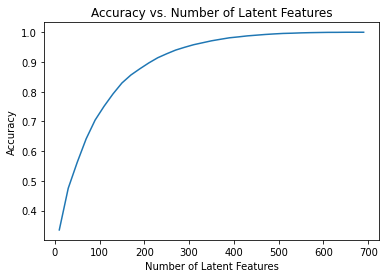

In [14]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [0]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create a user-item matrix for the training dataframe
    user_item_train = df_train.groupby(['user_id','article_id']).max().unstack()
    user_item_train = (user_item_train.notnull()).astype('int')


    #Get user ids for the testing user-item matrix -> intersection between users in the training and set dataframes

    test_idx = df_test['user_id'].unique()
    train_idx = df_train['user_id'].unique()
    test_train_idx = np.intersect1d(train_idx,test_idx, assume_unique=True)

    #Get article ids for the testing user-item matrix -> intersection between articles in the training and set dataframes

    test_arts = df_test['article_id'].unique()
    train_arts = df_train['article_id'].unique()
    test_train_arts = np.intersect1d(train_arts,test_arts, assume_unique=True)

    # Users that are both on test and training datasets are on the top of the dataframe now
    df_test_new = pd.concat([(df_test[df_test['user_id'].isin(test_train_idx)]),(df_test[~df_test['user_id'].isin(test_train_idx)])], axis=0)

    # Create a user-item matrix for the test dataframe
    user_item_test = df_test_new.groupby(['user_id','article_id']).max().unstack()
    user_item_test = (user_item_test.notnull()).astype('int')

    return user_item_train, user_item_test, test_idx, test_arts, test_train_idx, test_train_arts

user_item_train, user_item_test, test_idx, test_arts, test_train_idx, test_train_arts = create_test_and_train_user_item(df_train, df_test)

In [0]:
# User-Item matrix with only the users that are on both test and training sets
user_item_test_new = user_item_test[0:len(test_train_idx)]

In [120]:
#How many users can we make predicstion for in the test set?

# Answer -> The number of users that are both on the train and test datasets
print('How many users can we make predicstion for in the test set? \n= {}'.format(user_item_test_new.shape[0]))

How many users can we make predicstion for in the test set? 
= 20


In [121]:
#How many users in the test set are we not able to make predictions for because of the cold start problem?

# Answer -> All the users that were not in the training dataset
len(test_idx) - user_item_test.shape[0]
print('How many users in the test set are we not able to make predictions for because of the cold start problem? \n= {}'.format(len(test_idx) - user_item_test_new.shape[0]))

How many users in the test set are we not able to make predictions for because of the cold start problem? 
= 662


In [122]:
# How many articles can we make predictions for in the test set?

# Answer -> All the articles that were on both training and test datasets
print('How many users in the test set are we not able to make predictions for because of the cold start problem? \n= {}'.format(user_item_test_new.shape[1]))


How many users in the test set are we not able to make predictions for because of the cold start problem? 
= 574


In [123]:
# How many movies in the test set are we not able to make predictions for because of the cold start problem?

# Answer -> We are able to make predictions to all the articles
print('How many movies in the test set are we not able to make predictions for because of the cold start problem? \n= {}'.format(len(test_arts) - user_item_test_new.shape[1]))


How many movies in the test set are we not able to make predictions for because of the cold start problem? 
= 0


In [36]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [0]:
# Fit Matrixes for SVD

u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_test, s_test, vt_test = np.linalg.svd(user_item_test)

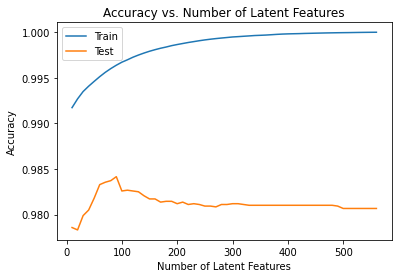

In [142]:
num_latent_feats = np.arange(10,570,10)
train_errs, test_errs = [], []

for k in num_latent_feats:
    # restructure with k latent features (train set)
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # restructure with k latent features (test set)
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
        
    # take dot product (train set)
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))

    # take dot product (test set)
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute accuracy
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_est_train.flatten()))
    test_errs.append(accuracy_score(user_item_test_new.values.flatten(), user_item_est_test[0:len(test_train_idx)].flatten()))

    #print("{} Latent Fratures \t Train Accuracy: {} | Test Accuracy: {} ".format(k,train_errs[k-1],test_errs[k-1]))

    
    
plt.figure()
plt.plot(num_latent_feats, train_errs, label='Train')
plt.plot(num_latent_feats, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()

In [143]:
# Optimal number of Latent Features
opt_latent_feat = 10 + 10*(np.where(test_errs == max(test_errs))[0][0])
# Accuracy at optimal latent feature number
opt_acc = max(test_errs)

print('Optimal Number of Latent Features : {} \nAccuracy: {}'.format(opt_latent_feat, opt_acc))

Optimal Number of Latent Features : 90 
Accuracy: 0.9841463414634146


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The best results were achieved using **90** latent features, where the model reached **98.41%** of accuracy predicting the test data.

This results are quite expressive, however the model by itself wouldn't be enough to deploy a complete solution, as it's not able to give recommendations to new users.

Hence, the best solution would be blending our **User-User Based Collaborative Filtering** with the **Rank-Based Recommendations**, which would enable us to make recommendations to all the cases.

That being said, the best way to evaluate our solution, would be an **A/B Test**.

One interesting metric to evaluate the performance of our recommendation system would be the average time users spent on a article's page.

As our system has as objective recommend the most interessant articles to each user, it's expected that the average time users spent on a article's page is going to increase.

$$ \pi = \frac{\delta timepage_{avg}}{users} $$

Hence, our hypothesis would be:


$$ H0: \pi_{new} - \pi_{old} \leq 0 $$
$$ H1: \pi_{new} - \pi_{old} > 0 $$
